## Data Preprocessing

In [323]:
from pyspark.sql import SparkSession 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, ChiSqSelector, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
from pyspark.sql.functions import col
from pyspark.ml.linalg import Vectors
# from keras.models import Sequential
# from keras.layers import Dense
# from elephas.spark_model import SparkModel
# from elephas.utils.rdd_utils import to_simple_rdd
from sklearn.metrics import accuracy_score
# from pyspark.mllib.regression import LabeledPoint
# import tensorflow as tf

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [324]:

spark = SparkSession.builder.appName('Data Cleaning').getOrCreate()

In [325]:
df = spark.read.csv('ddos_data.csv', header=True, inferSchema=True)

In [326]:
df.show(5)

+-----------------+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------------+---------------------+---------------------+--------------------+----

In [327]:
# num of rows
df.count()

225745

In [328]:
# num of columns
len(df.columns)

79

In [329]:
from pyspark.sql.functions import isnan, when, count, col

In [330]:
df.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in df.columns]).show()

+-----------------+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------------+---------------------+---------------------+--------------------+----

In [331]:
df_columns = [col.strip().replace('.', '_').replace(' ', '_').replace('`', '') for col in df.columns]
df = df.toDF(*df_columns)

In [332]:
df.show(5)

+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

#### <a>Missing values

In [333]:
missing_value = df.select('*',
                          sum(when(isnan(col(cols)) | col(cols).isNull(), 1).otherwise(0)
                          for cols in df.columns).alias('Missing Value')

                          )

In [334]:
missing_value.show(5)

+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

In [335]:
missing_value.filter(col('Missing value') == 1).show()

+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

In [336]:
# Drop missing value and check the last result after deleting
drop_null = missing_value.dropna(how='any')

drop_null.filter(col('Missing value') == 1).show()


+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

#### <a>Duplicate Value

In [337]:
# Duplicate rows
df_dup = df.exceptAll(df.dropDuplicates())
df_dup.show(5)

+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

In [338]:
# Number of duplicate rows
df_dup.count()

2633

In [339]:
# Original Rows
df.count()

225745

In [340]:
# Verify the number of rows after drop duplciate
df_no_dup = df.dropDuplicates()
df_no_dup.count() == (df.count()- df_dup.count())

True

In [341]:
# Copy to df_new
df_new = df_no_dup.alias('df_new')

### Label Encoding

In [342]:
# Check unique label
unique = df_new.select('Label').distinct().collect()
unique

[Row(Label='BENIGN'), Row(Label='DDoS')]

In [343]:
# Encode the feature Label
label = {
    'BENIGN': 0,
    'DDoS': 1
}

df_converted = df_new.withColumn('Labels_encoded', when(df_new['Label'] == 'DDoS', 1).otherwise(0))
df_converted.show(5)


+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

In [344]:
# Verify label DDoS or BENIGN
df_converted.filter(col('Labels_encoded') == 1).show(5)

+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

## EDA

### Descriptive Statistics

In [345]:
# Build the quakes frequency dataframe using the year field and counts for each year
df_freq = df_new.groupBy('label').count().withColumnRenamed('count', 'Counts')
# Preview df_quake_freq
df_freq.show(5)

+------+------+
| label|Counts|
+------+------+
|BENIGN| 95096|
|  DDoS|128016|
+------+------+



In [346]:
df_new.printSchema()

root
 |-- Destination_Port: integer (nullable = true)
 |-- Flow_Duration: integer (nullable = true)
 |-- Total_Fwd_Packets: integer (nullable = true)
 |-- Total_Backward_Packets: integer (nullable = true)
 |-- Total_Length_of_Fwd_Packets: integer (nullable = true)
 |-- Total_Length_of_Bwd_Packets: integer (nullable = true)
 |-- Fwd_Packet_Length_Max: integer (nullable = true)
 |-- Fwd_Packet_Length_Min: integer (nullable = true)
 |-- Fwd_Packet_Length_Mean: double (nullable = true)
 |-- Fwd_Packet_Length_Std: double (nullable = true)
 |-- Bwd_Packet_Length_Max: integer (nullable = true)
 |-- Bwd_Packet_Length_Min: integer (nullable = true)
 |-- Bwd_Packet_Length_Mean: double (nullable = true)
 |-- Bwd_Packet_Length_Std: double (nullable = true)
 |-- Flow_Bytes/s: double (nullable = true)
 |-- Flow_Packets/s: double (nullable = true)
 |-- Flow_IAT_Mean: double (nullable = true)
 |-- Flow_IAT_Std: double (nullable = true)
 |-- Flow_IAT_Max: integer (nullable = true)
 |-- Flow_IAT_Min: in

In [347]:
# Create max Total_Fwd_packets with df_new
df_max = df_new.groupBy('label').max('Total_Fwd_Packets').withColumnRenamed('max(Total_Fwd_Packets)', 'Max_Total_Fwd_Packets')


In [348]:
# Create avg Total_Fwd_packets with df_new
df_avg = df_new.groupBy('label').avg('Total_Fwd_Packets').withColumnRenamed('avg(Total_Fwd_Packets)', 'Avg_Total_Fwd_Packets')

In [349]:
# Join df_max, and df_avg to df_freq
df_freq1 = df_freq.join(df_avg, ['label']).join(df_max, ['label'])
# Preview df_freq
df_freq1.show(5)

+------+------+---------------------+---------------------+
| label|Counts|Avg_Total_Fwd_Packets|Max_Total_Fwd_Packets|
+------+------+---------------------+---------------------+
|BENIGN| 95096|     5.48792798855893|                 1932|
|  DDoS|128016|    4.472628421447319|                   11|
+------+------+---------------------+---------------------+



In [350]:
df_freq1.printSchema()

root
 |-- label: string (nullable = true)
 |-- Counts: long (nullable = false)
 |-- Avg_Total_Fwd_Packets: double (nullable = true)
 |-- Max_Total_Fwd_Packets: integer (nullable = true)



In [351]:
df_freq.dropna()
df_freq1.dropna()

DataFrame[label: string, Counts: bigint, Avg_Total_Fwd_Packets: double, Max_Total_Fwd_Packets: int]

In [352]:
df_freq1.show()

+------+------+---------------------+---------------------+
| label|Counts|Avg_Total_Fwd_Packets|Max_Total_Fwd_Packets|
+------+------+---------------------+---------------------+
|BENIGN| 95096|     5.48792798855893|                 1932|
|  DDoS|128016|    4.472628421447319|                   11|
+------+------+---------------------+---------------------+



In [353]:
df_new.describe().show()

+-------+-----------------+--------------------+------------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+------------------+-----------------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+------------------+--------------------+-----------------+------------------+--------------------+------------------+-------------------+-------------+-------------+-------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+----------------------+--------------------+-------------------+--------------------+-------------------+-------------------+------------------+--------------+

In [354]:
df_new.filter("Total_Fwd_Packets>5.48").show()

+----------------+-------------+-----------------+----------------------+---------------------------+---------------------------+---------------------+---------------------+----------------------+---------------------+---------------------+---------------------+----------------------+---------------------+------------+--------------+-------------+------------+------------+------------+-------------+------------+-----------+-----------+-----------+-------------+------------+-----------+-----------+-----------+-------------+-------------+-------------+-------------+-------------------+-----------------+-------------+-------------+-----------------+-----------------+------------------+-----------------+----------------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+--------------+-------------+-------------------+--------------------+--------------------+-------------------+------------------+--------------------+------------

### Reduce number of Features

In [355]:
# Drop columns with constant values
columns_to_drop = ['Bwd_PSH_Flags', 'Fwd_URG_Flags', 'Bwd_URG_Flags',
                      'CWE_Flag_Count', 'Fwd_Avg_Bytes/Bulk', 'Fwd_Avg_Packets/Bulk',
                      'Fwd_Avg_Bulk_Rate', 'Bwd_Avg_Bytes/Bulk', 'Bwd_Avg_Packets/Bulk',
                      'Bwd_Avg_Bulk_Rate']
new_df = df_converted.drop(*columns_to_drop)

In [356]:
new_df.columns

['Destination_Port',
 'Flow_Duration',
 'Total_Fwd_Packets',
 'Total_Backward_Packets',
 'Total_Length_of_Fwd_Packets',
 'Total_Length_of_Bwd_Packets',
 'Fwd_Packet_Length_Max',
 'Fwd_Packet_Length_Min',
 'Fwd_Packet_Length_Mean',
 'Fwd_Packet_Length_Std',
 'Bwd_Packet_Length_Max',
 'Bwd_Packet_Length_Min',
 'Bwd_Packet_Length_Mean',
 'Bwd_Packet_Length_Std',
 'Flow_Bytes/s',
 'Flow_Packets/s',
 'Flow_IAT_Mean',
 'Flow_IAT_Std',
 'Flow_IAT_Max',
 'Flow_IAT_Min',
 'Fwd_IAT_Total',
 'Fwd_IAT_Mean',
 'Fwd_IAT_Std',
 'Fwd_IAT_Max',
 'Fwd_IAT_Min',
 'Bwd_IAT_Total',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Max',
 'Bwd_IAT_Min',
 'Fwd_PSH_Flags',
 'Fwd_Header_Length34',
 'Bwd_Header_Length',
 'Fwd_Packets/s',
 'Bwd_Packets/s',
 'Min_Packet_Length',
 'Max_Packet_Length',
 'Packet_Length_Mean',
 'Packet_Length_Std',
 'Packet_Length_Variance',
 'FIN_Flag_Count',
 'SYN_Flag_Count',
 'RST_Flag_Count',
 'PSH_Flag_Count',
 'ACK_Flag_Count',
 'URG_Flag_Count',
 'ECE_Flag_Count',
 'Down/Up_Ratio',


In [357]:
df_Encoding = new_df.drop('Label')

In [358]:
# num of rows
df_Encoding.count()

223112

In [359]:
# num of columns
len(df_Encoding.columns)

69

### Visualization

In [360]:
# !pip install pyspark matplotlib pyspark_dist_explore

In [361]:
pandas_df = new_df.toPandas()

In [362]:
pandas_df.head(5)

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_Bytes/s,Flow_Packets/s,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_PSH_Flags,Fwd_Header_Length34,Bwd_Header_Length,Fwd_Packets/s,Bwd_Packets/s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,SYN_Flag_Count,RST_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,URG_Flag_Count,ECE_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segment_Size,Avg_Bwd_Segment_Size,Fwd_Header_Length55,Subflow_Fwd_Packets,Subflow_Fwd_Bytes,Subflow_Bwd_Packets,Subflow_Bwd_Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min,Label,Labels_encoded
0,53,163477,1,1,43,108,43,43,43.000000,0.000000,108,108,108.000000,0.000000,923.677337,12.234137,1.634770e+05,0.000000e+00,163477,163477,0,0.000,0.000,0,0,0,0.000,0.000000e+00,0,0,0,32,32,6.117068,6.117068,43,108,64.666667,37.527768,1408.333333,0,0,0,0,0,0,0,1,97.000000,43.000000,108.000000,32,1,43,1,108,-1,-1,0,32,0.0,0.000,0,0,0.0,0.00000,0,0,BENIGN,0
1,53,23634,1,1,45,109,45,45,45.000000,0.000000,109,109,109.000000,0.000000,6516.036219,84.623847,2.363400e+04,0.000000e+00,23634,23634,0,0.000,0.000,0,0,0,0.000,0.000000e+00,0,0,0,32,32,42.311923,42.311923,45,109,66.333333,36.950417,1365.333333,0,0,0,0,0,0,0,1,99.500000,45.000000,109.000000,32,1,45,1,109,-1,-1,0,32,0.0,0.000,0,0,0.0,0.00000,0,0,BENIGN,0
2,443,32292318,10,12,1177,4424,725,0,117.700000,229.469945,1460,0,368.666667,572.935398,173.446824,0.681277,1.537729e+06,3.505114e+06,10100000,42,22600000,2508352.111,4314478.849,10200000,114834,32200000,2925229.636,4.565433e+06,10200000,59,0,212,248,0.309671,0.371605,0,1460,243.521739,451.777386,204102.806300,0,0,0,1,0,0,0,1,254.590909,117.700000,368.666667,212,10,1177,12,4424,8192,5521,9,20,1245533.0,1597498.468,2375135,115931,10000000.0,60206.60688,10100000,9999479,BENIGN,0
3,53,349,2,2,78,110,39,39,39.000000,0.000000,55,55,55.000000,0.000000,538681.948400,11461.318050,1.163333e+02,9.902693e+01,191,4,4,4.000,0.000,4,4,191,191.000,0.000000e+00,191,191,0,64,64,5730.659026,5730.659026,39,55,45.400000,8.763561,76.800000,0,0,0,0,0,0,0,1,56.750000,39.000000,55.000000,64,2,78,2,110,-1,-1,1,32,0.0,0.000,0,0,0.0,0.00000,0,0,BENIGN,0
4,443,5702103,9,6,619,4032,342,0,68.777778,119.903897,1460,0,672.000000,724.198592,815.663975,2.630608,4.072931e+05,1.214427e+06,4594001,1,5702103,712762.875,1578321.941,4594001,1,964110,192822.000,2.643827e+05,527259,49,0,192,128,1.578365,1.052243,0,1460,290.687500,525.193516,275828.229200,0,0,0,1,0,0,0,0,310.066667,68.777778,672.000000,192,9,619,6,4032,8192,4916,8,20,0.0,0.000,0,0,0.0,0.00000,0,0,BENIGN,0


In [363]:
pandas_df.dtypes

Destination_Port                 int32
Flow_Duration                    int32
Total_Fwd_Packets                int32
Total_Backward_Packets           int32
Total_Length_of_Fwd_Packets      int32
Total_Length_of_Bwd_Packets      int32
Fwd_Packet_Length_Max            int32
Fwd_Packet_Length_Min            int32
Fwd_Packet_Length_Mean         float64
Fwd_Packet_Length_Std          float64
Bwd_Packet_Length_Max            int32
Bwd_Packet_Length_Min            int32
Bwd_Packet_Length_Mean         float64
Bwd_Packet_Length_Std          float64
Flow_Bytes/s                   float64
Flow_Packets/s                 float64
Flow_IAT_Mean                  float64
Flow_IAT_Std                   float64
Flow_IAT_Max                     int32
Flow_IAT_Min                     int32
Fwd_IAT_Total                    int32
Fwd_IAT_Mean                   float64
Fwd_IAT_Std                    float64
Fwd_IAT_Max                      int32
Fwd_IAT_Min                      int32
Bwd_IAT_Total            

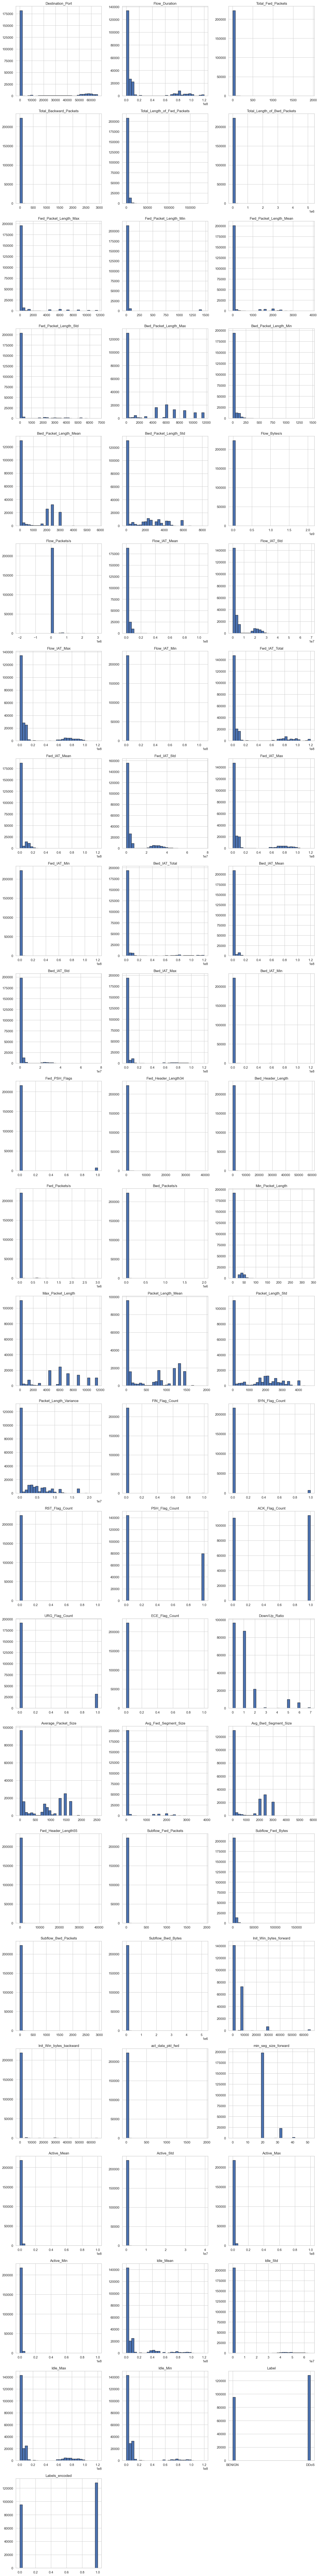

In [364]:
# Filter out infinite values
pandas_df = pandas_df.replace([np.inf, -np.inf], np.nan)
pandas_df = pandas_df.dropna()
# Plot histograms for all columns
num_columns = len(pandas_df.columns)
num_rows = (num_columns // 3) + 1

fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 5*num_rows))

for idx, col in enumerate(pandas_df.columns):
    row = idx // 3
    col_idx = idx % 3
    if num_rows == 1:
        axes[col_idx].hist(pandas_df[col].dropna(), bins=30, edgecolor='k')
        axes[col_idx].set_title(col)
    else:
        axes[row, col_idx].hist(pandas_df[col].dropna(), bins=30, edgecolor='k')
        axes[row, col_idx].set_title(col)

# Remove empty subplots
for i in range(num_columns, num_rows * 3):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()
plt.show()

In [365]:
# Set Pandas options to display all columns without truncation
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', None)  # Ensure it shows all rows if necessary

# Print the data types of the columns in the Pandas DataFrame
print(pandas_df.dtypes)

Destination_Port                 int32
Flow_Duration                    int32
Total_Fwd_Packets                int32
Total_Backward_Packets           int32
Total_Length_of_Fwd_Packets      int32
Total_Length_of_Bwd_Packets      int32
Fwd_Packet_Length_Max            int32
Fwd_Packet_Length_Min            int32
Fwd_Packet_Length_Mean         float64
Fwd_Packet_Length_Std          float64
Bwd_Packet_Length_Max            int32
Bwd_Packet_Length_Min            int32
Bwd_Packet_Length_Mean         float64
Bwd_Packet_Length_Std          float64
Flow_Bytes/s                   float64
Flow_Packets/s                 float64
Flow_IAT_Mean                  float64
Flow_IAT_Std                   float64
Flow_IAT_Max                     int32
Flow_IAT_Min                     int32
Fwd_IAT_Total                    int32
Fwd_IAT_Mean                   float64
Fwd_IAT_Std                    float64
Fwd_IAT_Max                      int32
Fwd_IAT_Min                      int32
Bwd_IAT_Total            

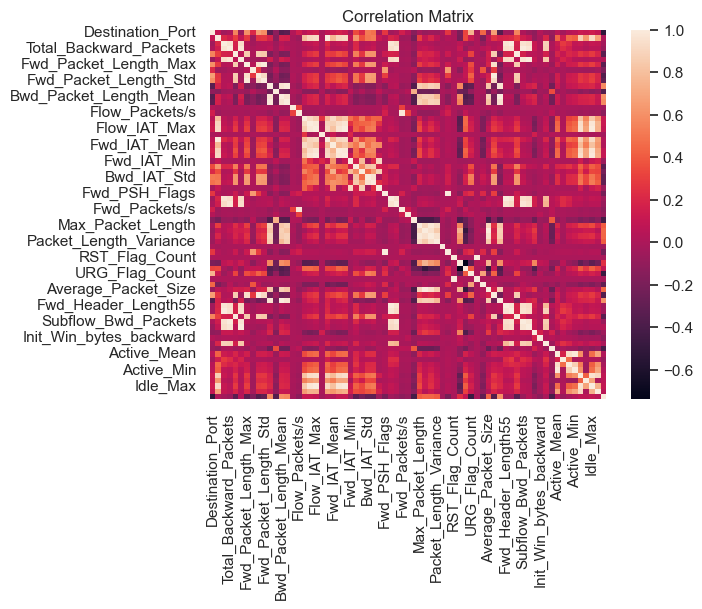

In [366]:
# Calculate correlation matrix
pandas_df1 = df_Encoding.toPandas() 
corr_matrix = pandas_df1.corr()

plt.figure()
sns.heatmap(corr_matrix)
plt.title('Correlation Matrix')
plt.show()

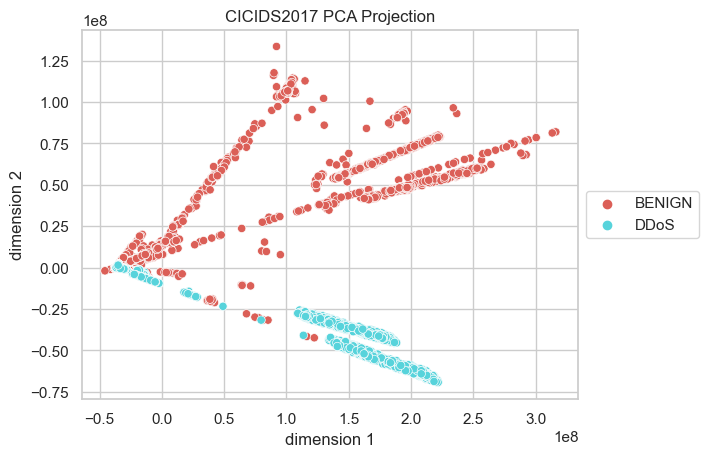

In [367]:
from sklearn.decomposition import PCA
subsample_df = pandas_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X) 

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'CICIDS2017 PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

## Model Development

In [368]:
pandas_df.dtypes

Destination_Port                 int32
Flow_Duration                    int32
Total_Fwd_Packets                int32
Total_Backward_Packets           int32
Total_Length_of_Fwd_Packets      int32
Total_Length_of_Bwd_Packets      int32
Fwd_Packet_Length_Max            int32
Fwd_Packet_Length_Min            int32
Fwd_Packet_Length_Mean         float64
Fwd_Packet_Length_Std          float64
Bwd_Packet_Length_Max            int32
Bwd_Packet_Length_Min            int32
Bwd_Packet_Length_Mean         float64
Bwd_Packet_Length_Std          float64
Flow_Bytes/s                   float64
Flow_Packets/s                 float64
Flow_IAT_Mean                  float64
Flow_IAT_Std                   float64
Flow_IAT_Max                     int32
Flow_IAT_Min                     int32
Fwd_IAT_Total                    int32
Fwd_IAT_Mean                   float64
Fwd_IAT_Std                    float64
Fwd_IAT_Max                      int32
Fwd_IAT_Min                      int32
Bwd_IAT_Total            

In [369]:
data = pandas_df 
data.dtypes 

Destination_Port                 int32
Flow_Duration                    int32
Total_Fwd_Packets                int32
Total_Backward_Packets           int32
Total_Length_of_Fwd_Packets      int32
Total_Length_of_Bwd_Packets      int32
Fwd_Packet_Length_Max            int32
Fwd_Packet_Length_Min            int32
Fwd_Packet_Length_Mean         float64
Fwd_Packet_Length_Std          float64
Bwd_Packet_Length_Max            int32
Bwd_Packet_Length_Min            int32
Bwd_Packet_Length_Mean         float64
Bwd_Packet_Length_Std          float64
Flow_Bytes/s                   float64
Flow_Packets/s                 float64
Flow_IAT_Mean                  float64
Flow_IAT_Std                   float64
Flow_IAT_Max                     int32
Flow_IAT_Min                     int32
Fwd_IAT_Total                    int32
Fwd_IAT_Mean                   float64
Fwd_IAT_Std                    float64
Fwd_IAT_Max                      int32
Fwd_IAT_Min                      int32
Bwd_IAT_Total            

### Spliting the data and Feature selection using Random Forest

In [370]:
# Convert data to Pyspark DataFrame
data = spark.createDataFrame(data)


In [371]:
data.printSchema()

root
 |-- Destination_Port: long (nullable = true)
 |-- Flow_Duration: long (nullable = true)
 |-- Total_Fwd_Packets: long (nullable = true)
 |-- Total_Backward_Packets: long (nullable = true)
 |-- Total_Length_of_Fwd_Packets: long (nullable = true)
 |-- Total_Length_of_Bwd_Packets: long (nullable = true)
 |-- Fwd_Packet_Length_Max: long (nullable = true)
 |-- Fwd_Packet_Length_Min: long (nullable = true)
 |-- Fwd_Packet_Length_Mean: double (nullable = true)
 |-- Fwd_Packet_Length_Std: double (nullable = true)
 |-- Bwd_Packet_Length_Max: long (nullable = true)
 |-- Bwd_Packet_Length_Min: long (nullable = true)
 |-- Bwd_Packet_Length_Mean: double (nullable = true)
 |-- Bwd_Packet_Length_Std: double (nullable = true)
 |-- Flow_Bytes/s: double (nullable = true)
 |-- Flow_Packets/s: double (nullable = true)
 |-- Flow_IAT_Mean: double (nullable = true)
 |-- Flow_IAT_Std: double (nullable = true)
 |-- Flow_IAT_Max: long (nullable = true)
 |-- Flow_IAT_Min: long (nullable = true)
 |-- Fwd_IAT

In [372]:
data.columns

['Destination_Port',
 'Flow_Duration',
 'Total_Fwd_Packets',
 'Total_Backward_Packets',
 'Total_Length_of_Fwd_Packets',
 'Total_Length_of_Bwd_Packets',
 'Fwd_Packet_Length_Max',
 'Fwd_Packet_Length_Min',
 'Fwd_Packet_Length_Mean',
 'Fwd_Packet_Length_Std',
 'Bwd_Packet_Length_Max',
 'Bwd_Packet_Length_Min',
 'Bwd_Packet_Length_Mean',
 'Bwd_Packet_Length_Std',
 'Flow_Bytes/s',
 'Flow_Packets/s',
 'Flow_IAT_Mean',
 'Flow_IAT_Std',
 'Flow_IAT_Max',
 'Flow_IAT_Min',
 'Fwd_IAT_Total',
 'Fwd_IAT_Mean',
 'Fwd_IAT_Std',
 'Fwd_IAT_Max',
 'Fwd_IAT_Min',
 'Bwd_IAT_Total',
 'Bwd_IAT_Mean',
 'Bwd_IAT_Std',
 'Bwd_IAT_Max',
 'Bwd_IAT_Min',
 'Fwd_PSH_Flags',
 'Fwd_Header_Length34',
 'Bwd_Header_Length',
 'Fwd_Packets/s',
 'Bwd_Packets/s',
 'Min_Packet_Length',
 'Max_Packet_Length',
 'Packet_Length_Mean',
 'Packet_Length_Std',
 'Packet_Length_Variance',
 'FIN_Flag_Count',
 'SYN_Flag_Count',
 'RST_Flag_Count',
 'PSH_Flag_Count',
 'ACK_Flag_Count',
 'URG_Flag_Count',
 'ECE_Flag_Count',
 'Down/Up_Ratio',


In [373]:
data_2= data.drop("Label")

In [374]:
data_spark = data_2 

In [375]:
data_spark.printSchema()

root
 |-- Destination_Port: long (nullable = true)
 |-- Flow_Duration: long (nullable = true)
 |-- Total_Fwd_Packets: long (nullable = true)
 |-- Total_Backward_Packets: long (nullable = true)
 |-- Total_Length_of_Fwd_Packets: long (nullable = true)
 |-- Total_Length_of_Bwd_Packets: long (nullable = true)
 |-- Fwd_Packet_Length_Max: long (nullable = true)
 |-- Fwd_Packet_Length_Min: long (nullable = true)
 |-- Fwd_Packet_Length_Mean: double (nullable = true)
 |-- Fwd_Packet_Length_Std: double (nullable = true)
 |-- Bwd_Packet_Length_Max: long (nullable = true)
 |-- Bwd_Packet_Length_Min: long (nullable = true)
 |-- Bwd_Packet_Length_Mean: double (nullable = true)
 |-- Bwd_Packet_Length_Std: double (nullable = true)
 |-- Flow_Bytes/s: double (nullable = true)
 |-- Flow_Packets/s: double (nullable = true)
 |-- Flow_IAT_Mean: double (nullable = true)
 |-- Flow_IAT_Std: double (nullable = true)
 |-- Flow_IAT_Max: long (nullable = true)
 |-- Flow_IAT_Min: long (nullable = true)
 |-- Fwd_IAT

In [376]:
# Asemble feature into a vector
feature_columns = [col for col in data_spark.columns if col != 'Labels_encoded']
# Convert columns to a feature vector
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "features")

In [377]:
# Split data into training and test sets
train_df, test_df = data_spark.randomSplit([0.7,0.3], seed=42)

In [378]:
# Define the RandomForestClassifier
rf = RandomForestClassifier(labelCol="Labels_encoded", featuresCol="features",numTrees=50,seed=42)


In [379]:
# Create a Pipeline
pipeline = Pipeline(stages=[assembler,rf])

In [380]:
# Train the initial model
initial_model = pipeline.fit(train_df)

In [381]:
# Extract feature importances
rf_model = initial_model.stages[-1]
importances = rf_model.featureImportances
importances_list = importances.toArray().tolist()

In [382]:
# Get the features names and their importances
feature_importance_df = pd.DataFrame({'Feature': feature_columns,'Importance':importances_list})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)


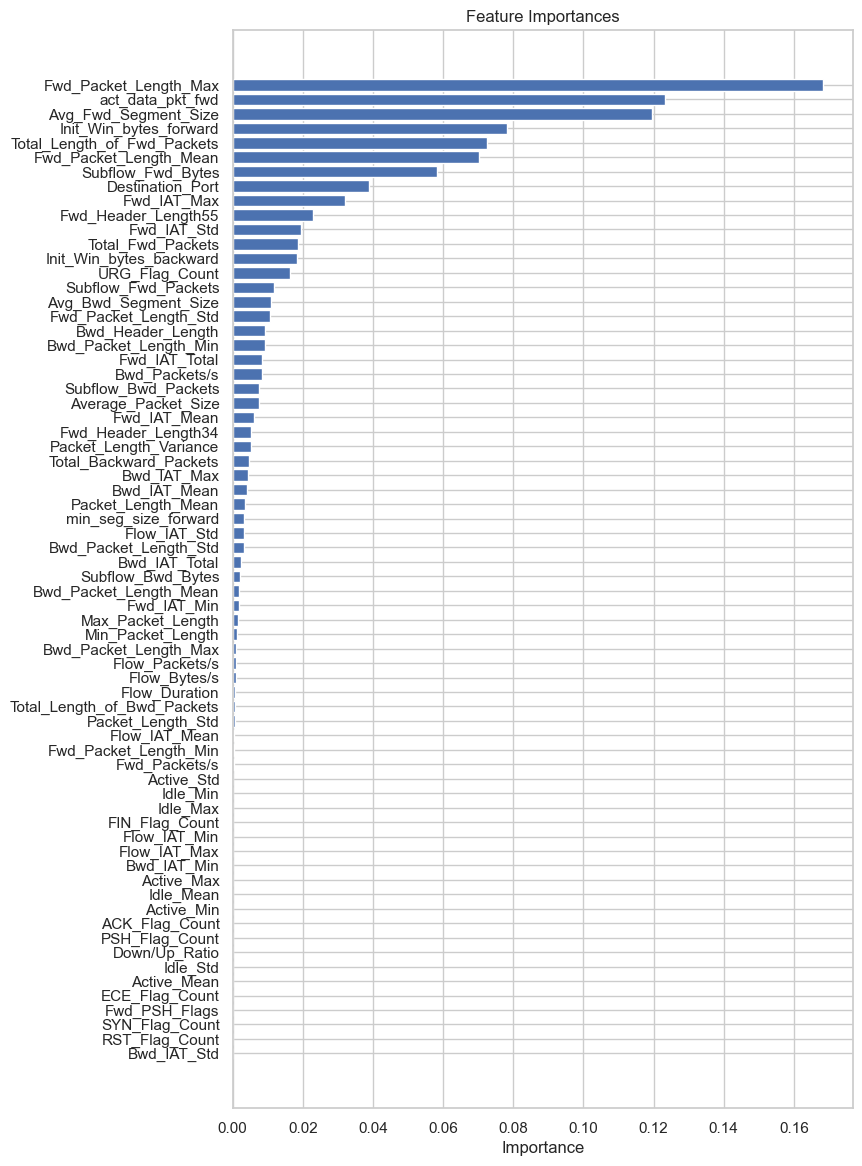

In [383]:
# Plot feature importances
plt.figure(figsize=(8, 14))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], align="center")
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.gca().invert_yaxis()
plt.show()

In [384]:
# Select top N features
N = 45  # For example, select top 20 features
top_features = feature_importance_df.head(N)['Feature'].tolist()
print(f"Top {N} features: {top_features}")

Top 45 features: ['Fwd_Packet_Length_Max', 'act_data_pkt_fwd', 'Avg_Fwd_Segment_Size', 'Init_Win_bytes_forward', 'Total_Length_of_Fwd_Packets', 'Fwd_Packet_Length_Mean', 'Subflow_Fwd_Bytes', 'Destination_Port', 'Fwd_IAT_Max', 'Fwd_Header_Length55', 'Fwd_IAT_Std', 'Total_Fwd_Packets', 'Init_Win_bytes_backward', 'URG_Flag_Count', 'Subflow_Fwd_Packets', 'Avg_Bwd_Segment_Size', 'Fwd_Packet_Length_Std', 'Bwd_Header_Length', 'Bwd_Packet_Length_Min', 'Fwd_IAT_Total', 'Bwd_Packets/s', 'Subflow_Bwd_Packets', 'Average_Packet_Size', 'Fwd_IAT_Mean', 'Fwd_Header_Length34', 'Packet_Length_Variance', 'Total_Backward_Packets', 'Bwd_IAT_Max', 'Bwd_IAT_Mean', 'Packet_Length_Mean', 'min_seg_size_forward', 'Flow_IAT_Std', 'Bwd_Packet_Length_Std', 'Bwd_IAT_Total', 'Subflow_Bwd_Bytes', 'Bwd_Packet_Length_Mean', 'Fwd_IAT_Min', 'Max_Packet_Length', 'Min_Packet_Length', 'Bwd_Packet_Length_Max', 'Flow_Packets/s', 'Flow_Bytes/s', 'Flow_Duration', 'Total_Length_of_Bwd_Packets', 'Packet_Length_Std']


In [385]:
# Create a new VectorAssembler with the selected top features
top_assembler = VectorAssembler(inputCols=top_features, outputCol="features")

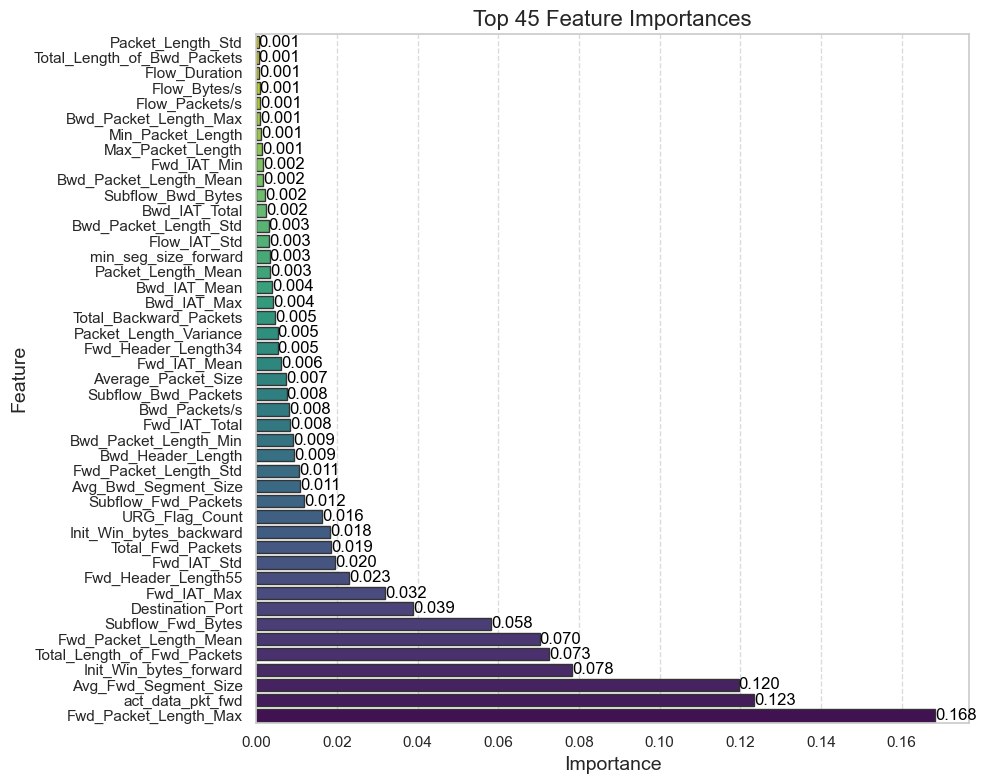

In [386]:
top_feature_importance_df = feature_importance_df.head(N)

# Plot top 20 feature importances with improved design
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Create a color palette
palette = sns.color_palette("viridis", N)

# Plot the horizontal bar chart with colors
barplot = sns.barplot(
    x="Importance",
    y="Feature",
    data=top_feature_importance_df,
    palette=palette,
    edgecolor=".2"
)

# Add labels and title
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.title("Top 45 Feature Importances", fontsize=16)

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add annotations to show the exact importance values
for index, value in enumerate(top_feature_importance_df['Importance']):
    plt.text(
        value,
        index,
        f'{value:.3f}',
        color='black',
        ha="left",
        va="center",
        fontsize=12
    )

# Invert the y-axis to have the most important feature at the top
plt.gca().invert_yaxis()

# Show the plot
plt.tight_layout()
plt.show()

### Training model Random Forest

In [387]:
# Define a new RandomForestClassifier with the selected features
rf_top = RandomForestClassifier(labelCol="Labels_encoded", featuresCol="features", numTrees=50, seed=42)


In [388]:
# Create a new pipeline with the selected features
pipeline_top = Pipeline(stages=[top_assembler, rf_top])

In [389]:
# Train the new model with the selected features
final_model = pipeline_top.fit(train_df)

In [390]:
# Make predictions with the new model
predictions = final_model.transform(test_df)

In [391]:
# # Evaluate the final model
# evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="accuracy")
# accuracy = evaluator.evaluate(predictions)
# print(f"Test Accuracy with top {N} features = {accuracy}")
evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Test Accuracy with top {N} features = {accuracy}")


Test Accuracy with top 45 features = 0.99927727170067


#### Model evalutaion

In [392]:
predictions.select("Labels_encoded", "prediction").show()

+--------------+----------+
|Labels_encoded|prediction|
+--------------+----------+
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
|             0|       0.0|
+--------------+----------+
only showing top 20 rows



In [393]:
# Convert the Spark DataFrame to a Pandas DataFrame
preds_and_labels = predictions.select("Labels_encoded", "prediction").toPandas()


In [394]:
# Compute the confusion matrix
cm = confusion_matrix(preds_and_labels['Labels_encoded'], preds_and_labels['prediction'])

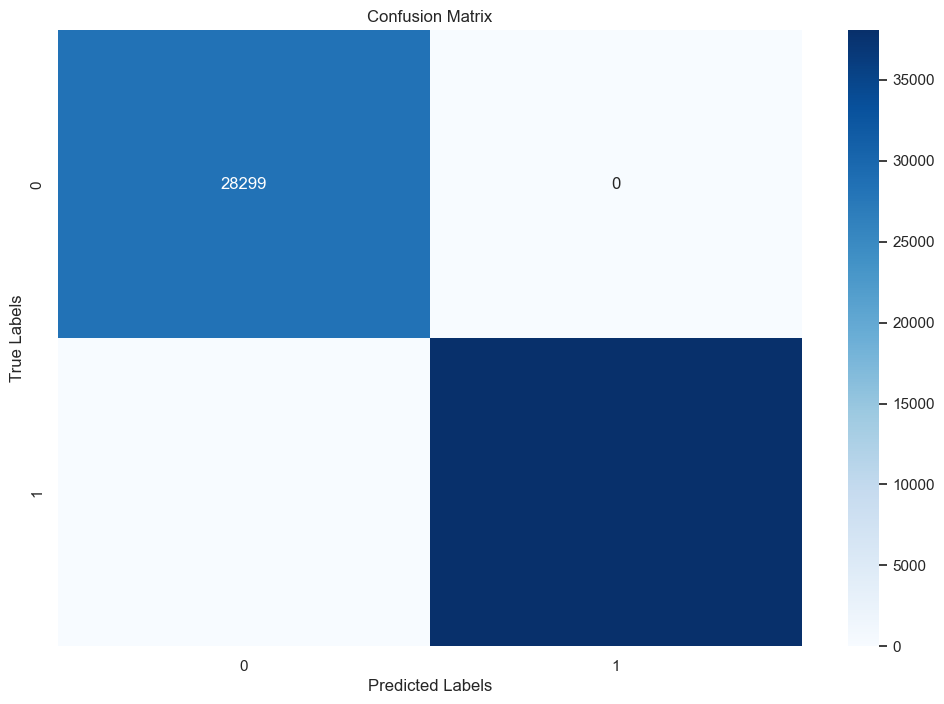

In [395]:
class_labels = sorted(preds_and_labels['Labels_encoded'].unique())

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [396]:
# Compute precision, recall, and F1-score using MulticlassClassificationEvaluator
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions)
recall = recall_evaluator.evaluate(predictions)
f1_score = f1_evaluator.evaluate(predictions)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

Precision: 0.9992784954971341
Recall: 0.99927727170067
F1-Score: 0.9992773502302705


In [397]:
from sklearn.metrics import classification_report, accuracy_score

# Extract true and predicted labels
true_labels = preds_and_labels['Labels_encoded']
predicted_labels = preds_and_labels['prediction']

# Print classification report which includes precision, recall, and F1-score
print(classification_report(true_labels, predicted_labels))

# Print accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28299
           1       1.00      1.00      1.00     38116

    accuracy                           1.00     66415
   macro avg       1.00      1.00      1.00     66415
weighted avg       1.00      1.00      1.00     66415

Accuracy: 0.9993


### Logistic regression

In [398]:
# Define a new LogisticRegression with the selected features
lr = LogisticRegression(labelCol="Labels_encoded", featuresCol="features", maxIter=100, regParam=0.01)

In [399]:
# Create a pipeline
pipeline = Pipeline(stages=[assembler, lr])

In [400]:
# Train the initial model
initial_model = pipeline.fit(train_df)

In [401]:
# Extract coefficients (feature importances)
coefficients = initial_model.stages[-1].coefficients
coefficients_list = coefficients.toArray().tolist()

In [402]:
# Define a new LogisticRegression with the selected features
lr_top = LogisticRegression(labelCol="Labels_encoded", featuresCol="features", maxIter=100, regParam=0.01)


In [403]:
# Create a new pipeline with the selected features
pipeline_top = Pipeline(stages=[top_assembler, lr_top])

In [404]:
# Train the new model with the selected features
final_model = pipeline_top.fit(train_df)

In [405]:
# Make predictions with the new model
predictions_log = final_model.transform(test_df)

In [406]:
# Evaluate the final model
evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions_log)
print(f"Test Accuracy with top {N} features = {accuracy}")

Test Accuracy with top 45 features = 0.9711962659037868


#### Model evaluation

In [407]:
# Compute the confusion matrix
predictions_log.groupBy("Labels_encoded", "prediction").count().show()

+--------------+----------+-----+
|Labels_encoded|prediction|count|
+--------------+----------+-----+
|             1|       0.0|   17|
|             0|       1.0| 1896|
|             0|       0.0|26403|
|             1|       1.0|38099|
+--------------+----------+-----+



In [408]:
# Convert the Spark DataFrame to a Pandas DataFrame
preds_and_labels = predictions_log.select("Labels_encoded", "prediction").toPandas()

In [409]:
# Compute the confusion matrix
cm_og = confusion_matrix(preds_and_labels['Labels_encoded'], preds_and_labels['prediction'])

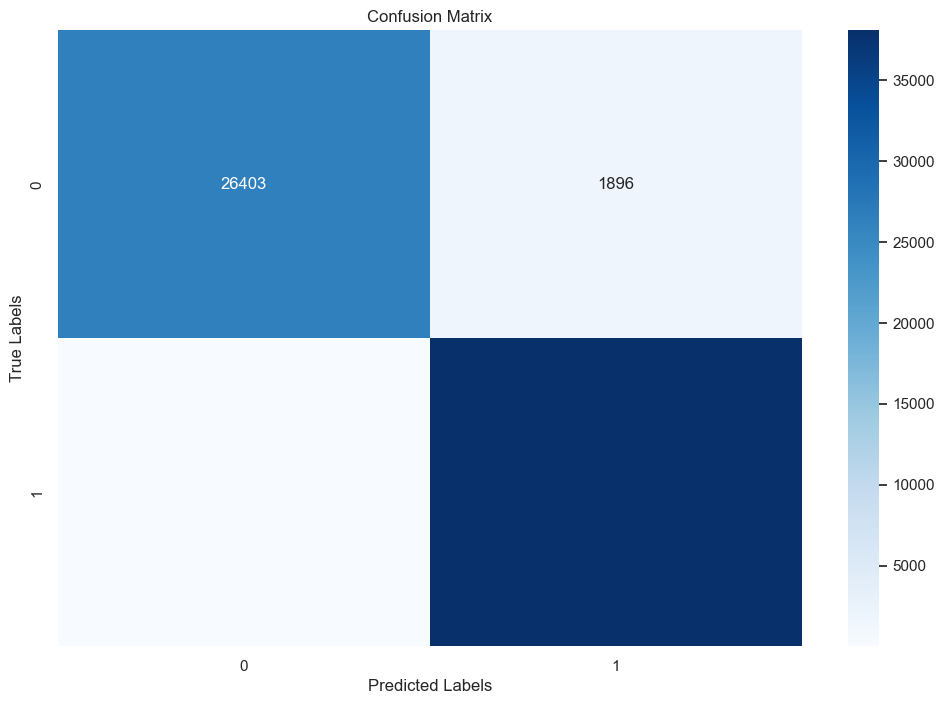

In [410]:
class_labels = sorted(preds_and_labels['Labels_encoded'].unique())

plt.figure(figsize=(12, 8))
sns.heatmap(cm_og, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [411]:
# Compute precision, recall, and F1-score using MulticlassClassificationEvaluator
precision_evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="weightedRecall")
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Labels_encoded", predictionCol="prediction", metricName="f1")

precision = precision_evaluator.evaluate(predictions_log)
recall = recall_evaluator.evaluate(predictions_log)
f1_score = f1_evaluator.evaluate(predictions_log)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1_score}")

Precision: 0.9725192605328565
Recall: 0.9711962659037868
F1-Score: 0.971048163337827


In [412]:
from sklearn.metrics import classification_report, accuracy_score

# Extract true and predicted labels
true_labels = preds_and_labels['Labels_encoded']
predicted_labels = preds_and_labels['prediction']

# Print classification report which includes precision, recall, and F1-score
print(classification_report(true_labels, predicted_labels))

# Print accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy:.4f}')

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     28299
           1       0.95      1.00      0.98     38116

    accuracy                           0.97     66415
   macro avg       0.98      0.97      0.97     66415
weighted avg       0.97      0.97      0.97     66415

Accuracy: 0.9712
